In [2]:
%load_ext memory_profiler
import xarray as xr
import numpy as np
from RAiDER.models import HRES

In [80]:
import logging

In [84]:
logger = logging.getLogger('RAiDER')
for handler in logger.handlers[:]:
    if isinstance(handler, logging.FileHandler):
        logger.removeHandler(handler)
        handler.close()

In [2]:
%%memit
# Load data
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_dataset.nc', 
                     chunks={'level':-1})

peak memory: 268.55 MiB, increment: 25.12 MiB


In [71]:
from opera_tropo.utils import round_mantissa
def get_ztd(lat:np.ndarray,
            lon:np.ndarray,
            temperature:np.ndarray,
            humidity:np.ndarray,
            z:np.ndarray,
            lnsp:np.ndarray) -> xr.Dataset:

    # Initialize HRES model
    hres_model = HRES()

    # Add temperature and specific humidity 
    hres_model._t = temperature
    hres_model._q = humidity

    # Use geopotential heights and log of surface pressure
    # to get pressure, geopotential, and geopotential height
    hres_model._p, hgt = hres_model._calculategeoh(z, lnsp)[1:]

    # Add latitude and longitude grid
    hres_model._lons, hres_model._lats = np.meshgrid(lon, lat)
    # Get altitudes
    hres_model._get_heights(hres_model._lats, hgt.transpose(1, 2, 0))
    del hgt

    # Re-structure arrays from (heights, lats, lons) to (lons, lats, heights)
    hres_model._p = np.flip(hres_model._p.transpose(1, 2, 0), axis=2)
    hres_model._t = np.flip(hres_model._t.transpose(1, 2, 0), axis=2)
    hres_model._q = np.flip(hres_model._q.transpose(1, 2, 0), axis=2)
    hres_model._zs = np.flip(hres_model._zs, axis=2)

    # Perform RAiDER computations
    hres_model._find_e()  # Compute partial pressure of water vapor
    # Interpolate to common heights 
    hres_model._uniform_in_z(_zlevels=None)
    # Fill out nan at lower and upper bonds
    hres_model._checkForNans()
    # Get wet and hydrostatic refractivity
    hres_model._get_wet_refractivity()
    hres_model._get_hydro_refractivity()
    hres_model._adjust_grid(hres_model.get_latlon_bounds())

    # Compute zenith delays at the weather model grid nodes
    hres_model._getZTD()

    #wet_ztd = hres_model._wet_ztd.astype(np.float32)
    #hydro_ztd = hres_model._hydrostatic_ztd.astype(np.float32)

    #round_mantissa(wet_ztd, 10)
    #round_mantissa(hydro_ztd, 12)

    # output dataset
    dims = ["latitude", "longitude", "height"]
    out_ds = xr.Dataset(
        data_vars={
            'wet_ztd':(dims, hres_model._wet_ztd),
            'hydrostatic_ztd':(dims, hres_model._hydrostatic_ztd),
        },
        coords={
            'height':("height", hres_model._zs),
            'latitude':("latitude", hres_model._lats[:, 0]),
            'longitude':("longitude", hres_model._lons[0, :]),
        }
    )
    return out_ds


In [72]:
from typing import Optional
from opera_tropo._pack import pack_ztd
def calculate_ztd(ds : xr.Dataset,
                  out_heights: Optional[list]=None,
                  chunk_size: Optional[list]=None) -> xr.Dataset:
    # Get ZTD 
    ztd_ds = get_ztd(lat=ds.latitude.values,
                     lon=ds.longitude.values,
                     temperature=ds.t.isel(time=0).values,
                     humidity=ds.q.isel(time=0).values,
                     z=ds.z.isel(time=0, level=0).values,
                     lnsp=ds.lnsp.isel(time=0, level=0).values)

    # Interpolate to output heights
    if out_heights is not None:
        ztd_ds = ztd_ds.interp(height=out_heights, method="cubic")

    # Packaging and rounding using product_info
    ztd_ds = pack_ztd(
        wet_ztd=ztd_ds.wet_ztd.values,
        hydrostatic_ztd=ztd_ds.hydrostatic_ztd.values,
        lons=ztd_ds.longitude,
        lats=ztd_ds.latitude,
        zs=ztd_ds.height,
        model_time=ds.time.data,
        chunk_size=chunk_size)

    return ztd_ds

In [73]:
%%time
%%memit
# drop time coord
da = ds.isel(time=0)
out1= calculate_ztd(ds)

peak memory: 1002.45 MiB, increment: 21.79 MiB
CPU times: user 3.77 s, sys: 288 ms, total: 4.06 s
Wall time: 3.94 s


In [60]:
from opera_tropo._pack import pack_ztd

out2 = pack_ztd(out1.wet_ztd.values.transpose(1,2,0),
         out1.hydrostatic_ztd.values.transpose(1,2,0),
         out1.longitude, out1.latitude, out1.height,
         ds.time.data, chunk_size={"time":1, "height": 64, 'longitude':64, 'latitude':64},
         keep_bits=True)

In [45]:
mm_height = out1.height[out1.height < 30e3]

In [41]:
out_height = [-500, -100, 0, 100, 500, 1000, 2000, 5000, 10e3, 15e3, 25e3]

In [53]:
%%time
ztd_xr = out1.interp(height=mm_height, method="cubic")

CPU times: user 27.7 s, sys: 68 ms, total: 27.8 s
Wall time: 278 ms


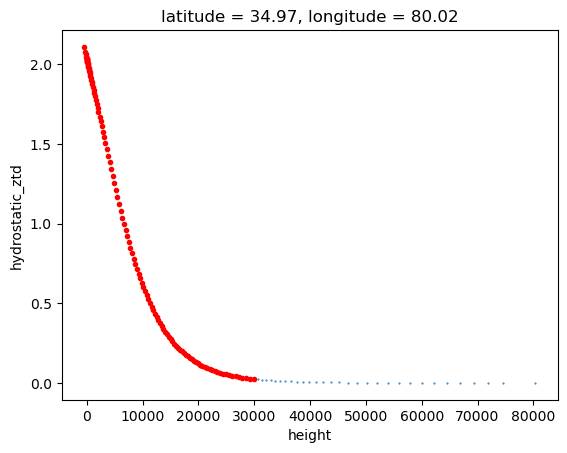

In [54]:
out1.hydrostatic_ztd[:,0,0].plot(marker='.', ms=1, lw=0)
ztd_xr.hydrostatic_ztd[:,0,0].plot(marker='o', color='red', ms=3, lw=0)

In [74]:
%%time
%%memit
from opera_tropo.core import calculate_ztd as ztd2
out_ds = ztd2(ds)

peak memory: 1025.79 MiB, increment: 23.13 MiB
CPU times: user 4.18 s, sys: 332 ms, total: 4.52 s
Wall time: 4.53 s


In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [75]:
np.testing.assert_allclose(out1.latitude, out_ds.latitude)
np.testing.assert_allclose(out1.longitude, out_ds.longitude)
np.testing.assert_allclose(out1.height, out_ds.height)

In [76]:
out2

<xarray.Dataset> Size: 24MB
Dimensions:            (time: 1, height: 145, latitude: 142, longitude: 143)
Coordinates:
  * time               (time) datetime64[ns] 8B 2024-02-15T12:00:00
  * height             (height) float64 1kB -500.0 -300.0 ... 7.458e+04 8.03e+04
  * latitude           (latitude) float64 1kB 34.97 34.9 34.83 ... 25.13 25.06
  * longitude          (longitude) float64 1kB 80.02 80.09 80.16 ... 89.93 90.0
    spatial_ref        int64 8B 0
Data variables:
    wet_delay          (time, height, latitude, longitude) float32 12MB dask.array<chunksize=(1, 64, 64, 64), meta=np.ndarray>
    hydrostatic_delay  (time, height, latitude, longitude) float32 12MB dask.array<chunksize=(1, 64, 64, 64), meta=np.ndarray>
Attributes: (12/17)
    Conventions:          CF-1.8
    title:                OPERA_L4_ZENITH_TROPO
    institution:          NASA Jet Propulsion Laboratory (JPL)
    contact:              opera-sds-ops@jpl.nasa.gov
    source:               ECMWF
    platform:             Model High Resolution 15-day Forecast (HRES)
    ...                   ...
    description:          OPERA One-way Tropospheric Zenith Delay for Synthet...
    comment:              Intersect/interpolate with DEM and multiple with -4...
    software:             RAiDER
    software_version:     0.5.3
    history:              Created on: 2025-03-22 03:34:59.986821+00:00
    reference_time:       2024-02-15 12:00:00

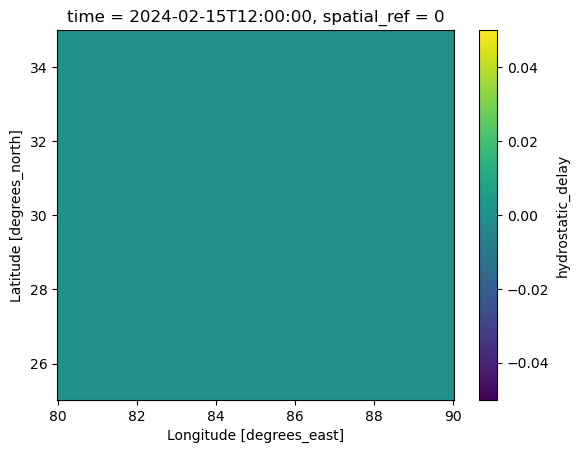

In [77]:
(out1.hydrostatic_delay - out_ds.isel(time=0).hydrostatic_delay).sum(dim='height').plot()

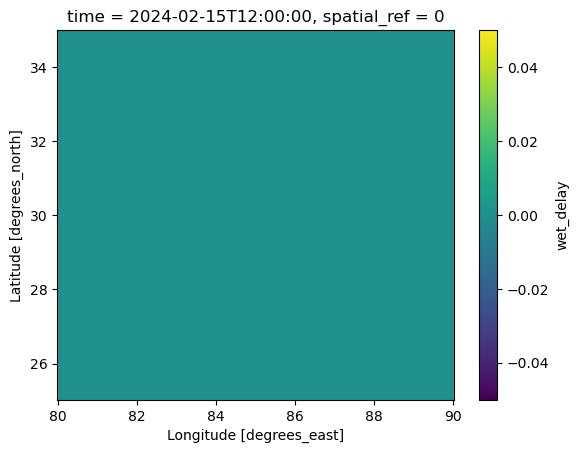

In [78]:
(out1.wet_delay- out_ds.isel(time=0).wet_delay).sum(dim='height').plot()

## Get the workflow

In [3]:
import xarray as xr
%load_ext memory_profiler

import psutil
process = psutil.Process()
def get_mem(process):
    mem = process.memory_info().rss / 1e9
    print("Mem: {mem:.2f}GB"))

In [ ]:
%%memit
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/ECMWF_TROP_202402151200_202402151200_1.nc',
                     chunks={'level':-1})

peak memory: 246.81 MiB, increment: 96.17 MiB


In [5]:
%%memit
chunks = {
    "longitude": 128,
    "latitude": 128,
    "time": 1,
    "level": 137,
}
ds = ds.chunk(chunks)

peak memory: 262.41 MiB, increment: 15.35 MiB


In [6]:
chunksizes = {key: value[0] for key, value in ds.chunksizes.items()}
print(chunksizes)

{'time': 1, 'level': 137, 'latitude': 128, 'longitude': 128}


In [7]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
os.chdir('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/notebooks')

In [8]:
from opera_tropo.run2 import calculate_ztd

In [9]:
from dask.distributed import Client
client = Client(
        n_workers=4,
        threads_per_worker=2,
        memory_limit='16GB',
    )
client.dashboard_link

'http://127.0.0.1:8787/status'

In [1]:
client.close()

NameError: name 'client' is not defined

In [44]:
from opera_tropo._pack import pack_ztd
from RAiDER.models.model_levels import A_137_HRES, LEVELS_137_HEIGHTS


In [ ]:
%%memit
import dask.array as da
isel = dict(longitude=slice(None,None),
            latitude=slice(None,None))

cols = ds.isel(isel).sizes.get("latitude")
rows = ds.isel(isel).sizes.get("longitude")
zlevels = np.flipud(LEVELS_137_HEIGHTS)

out_size = da.empty((cols, rows, len(zlevels)), dtype=np.float32)
template = pack_ztd(out_size, out_size,
                 lons=ds.isel(isel).longitude.data,
                 lats=ds.isel(isel).latitude.data,
                 zs=zlevels,
                 model_time=ds.time.data,
                 chunk_size={
                            "longitude": int(chunksizes["longitude"]),
                            "latitude": int(chunksizes["latitude"]),
                            "height": -1,
                            "time": 1,
                        },
                keep_bits=True,
                    )


23.25276672
peak memory: 36673.06 MiB, increment: 0.01 MiB


In [52]:
template

<xarray.Dataset> Size: 15GB
Dimensions:            (time: 1, height: 145, latitude: 2560, longitude: 5120)
Coordinates:
  * time               (time) datetime64[ns] 8B 2024-02-15T12:00:00
  * height             (height) float64 1kB -500.0 -300.0 ... 7.458e+04 8.03e+04
  * latitude           (latitude) float64 20kB 89.95 89.88 ... -89.88 -89.95
  * longitude          (longitude) float64 41kB 2.501e-07 0.07031 ... -0.07031
    spatial_ref        int64 8B 0
Data variables:
    wet_delay          (time, height, latitude, longitude) float32 8GB dask.array<chunksize=(1, 145, 128, 128), meta=np.ndarray>
    hydrostatic_delay  (time, height, latitude, longitude) float32 8GB dask.array<chunksize=(1, 145, 128, 128), meta=np.ndarray>
Attributes: (12/17)
    Conventions:          CF-1.8
    title:                OPERA_L4_ZENITH_TROPO
    institution:          NASA Jet Propulsion Laboratory (JPL)
    contact:              opera-sds-ops@jpl.nasa.gov
    source:               ECMWF
    platform:             Model High Resolution 15-day Forecast (HRES)
    ...                   ...
    description:          OPERA One-way Tropospheric Zenith Delay for Synthet...
    comment:              Intersect/interpolate with DEM and multiple with -4...
    software:             RAiDER
    software_version:     0.5.3
    history:              Created on: 2025-03-22 05:51:32.782254+00:00
    reference_time:       2024-02-15 12:00:00

In [18]:
%%memit
import numpy as np
import rioxarray
# Create an empty DataArray with the specified coordinates
template = xr.DataArray(
    None,  # Placeholder for the data
    coords={
        'time': ('time', ds.time.data),  # Time from the ds dataset
        'height': ('height', np.flipud(LEVELS_137_HEIGHTS)),  # Flipped height levels
        'latitude': ('latitude', ds.isel(latitude=slice(0, 500)).latitude.data),  # Latitude slice
        'longitude': ('longitude', ds.isel(longitude=slice(0, 500)).longitude.data),  # Longitude slice
    },
    dims=['time', 'height', 'latitude', 'longitude']
)
template = template.chunk({
                            "longitude": int(chunksizes["longitude"]),
                            "latitude": int(chunksizes["latitude"]),
                            "height": -1,
                            "time": 1,
                        })
template.rio.write_crs("EPSG:4326", inplace=True)

peak memory: 1687.91 MiB, increment: 1048.31 MiB


In [42]:
ENCODING_DEFAULTS = {
        "zlib": True,
        "complevel": 4,
        "shuffle": True,
        "chunksizes": [1, 64, 64, 64],
    }

In [43]:
%%time
%%memit
encoding = {var: ENCODING_DEFAULTS for var in template.data_vars}
ds.isel(isel).map_blocks(calculate_ztd,
        template=template).to_netcdf('test1.nc', encoding=encoding)

peak memory: 693.24 MiB, increment: 0.14 MiB
CPU times: user 1.43 s, sys: 960 ms, total: 2.39 s
Wall time: 26.7 s


In [ ]:
out_ds = xr.open_dataset('test.nc', chunks={})